FOR 15 SECONDS , SAMPLING RATE = 3000

In [117]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

In [175]:
BATCH_SIZE = 10
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 100
num_examples_to_generate = 10


In [120]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[[0,19,39,12,25,38,3,45,24,46,]]) #99,10,66,76,41
    train_music_2 = list(music_list[[4,22,36,6,9,31,11,13,37,21,]]) #65,32,53,22,19,80,89,
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

BASE_PATH = '/content/drive/MyDrive/genres_original'

In [121]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[[0,19,39,12,25,38,3,45,24,46,]]) #99,10,66,76,41
    train_music_2 = list(music_list[[4,22,36,6,9,31,11,13,37,21,]]) #65,32,53,22,19,80,89,
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

In [152]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=15)
    data_ = data_.reshape(1,45001)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [157]:
TrackSet_1, TrackSet_2 = DatasetLoader('hiphop')

In [158]:
sample = TrackSet_1[1]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=15)
ipd.Audio(sample_,rate=3000)

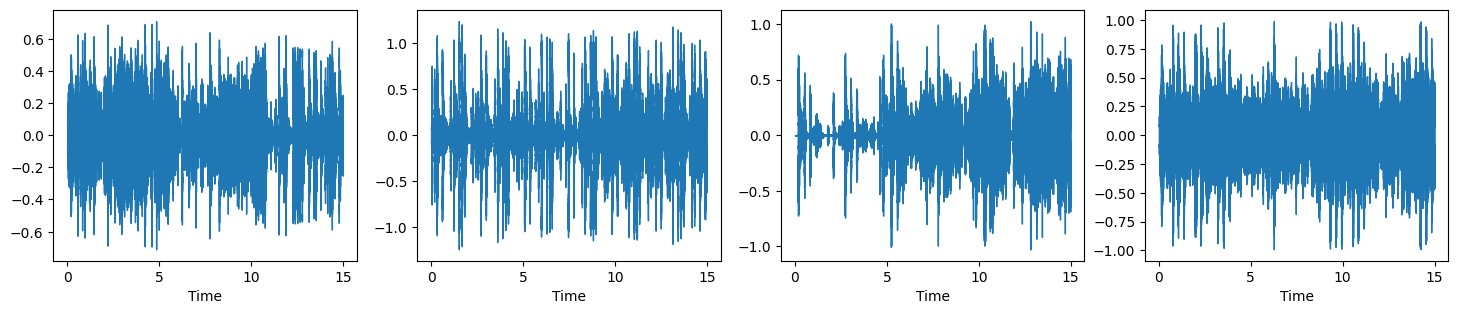

In [159]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    librosa.display.waveshow(j[0], sr=3000)


In [160]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

NETWORK ARCHITECTURE

In [161]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters, type='encode'):
        super(Resnet1DBlock, self).__init__();

        if type == 'encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2, padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1, padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        elif type == 'decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1, padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1, padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            raise ValueError("Invalid type parameter")

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)


In [162]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__();
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1, 45001)),
                layers.Conv1D(64, 1, 2),
                Resnet1DBlock(64, 1),
                layers.Conv1D(128, 1, 2),
                Resnet1DBlock(128, 1),
                layers.Conv1D(128, 1, 2),
                Resnet1DBlock(128, 1),
                layers.Conv1D(256, 1, 2),
                Resnet1DBlock(256, 1),
                # No activation
                layers.Flatten(),
                layers.Dense(latent_dim + latent_dim)
            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1, latent_dim)),
                Resnet1DBlock(512, 1, 'decode'),
                layers.Conv1DTranspose(512, 1, 1),
                Resnet1DBlock(256, 1, 'decode'),
                layers.Conv1DTranspose(256, 1, 1),
                Resnet1DBlock(128, 1, 'decode'),
                layers.Conv1DTranspose(128, 1, 1),
                Resnet1DBlock(64, 1, 'decode'),
                layers.Conv1DTranspose(64, 1, 1),
                # No activation
                layers.Conv1DTranspose(45001, 1, 1),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


In [163]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [164]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [165]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

LOSS OPTIMIZATION

In [166]:

@tf.function
def train_step(model, x, optimizer):

    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [167]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [168]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        times = np.arange(wave.shape[1]) / 3000  # Assuming the sample rate is 3000 Hz
        plt.plot(times, wave[0])
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

    plt.tight_layout()  # This replaces the deprecated tight_layout minimization
    plt.savefig(f'{save}_{epoch:04d}.png')
    plt.show()

# Example usage
# Assuming 'model', 'epoch', 'test_sample', and 'save_path' are predefined
# generate_and_save_images(model, epoch, test_sample, save_path)


In [169]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

TRAINING THE MODEL

Epoch: 20, ELBO: -5868.43017578125, time elapsed for current epoch: 0.26329469680786133


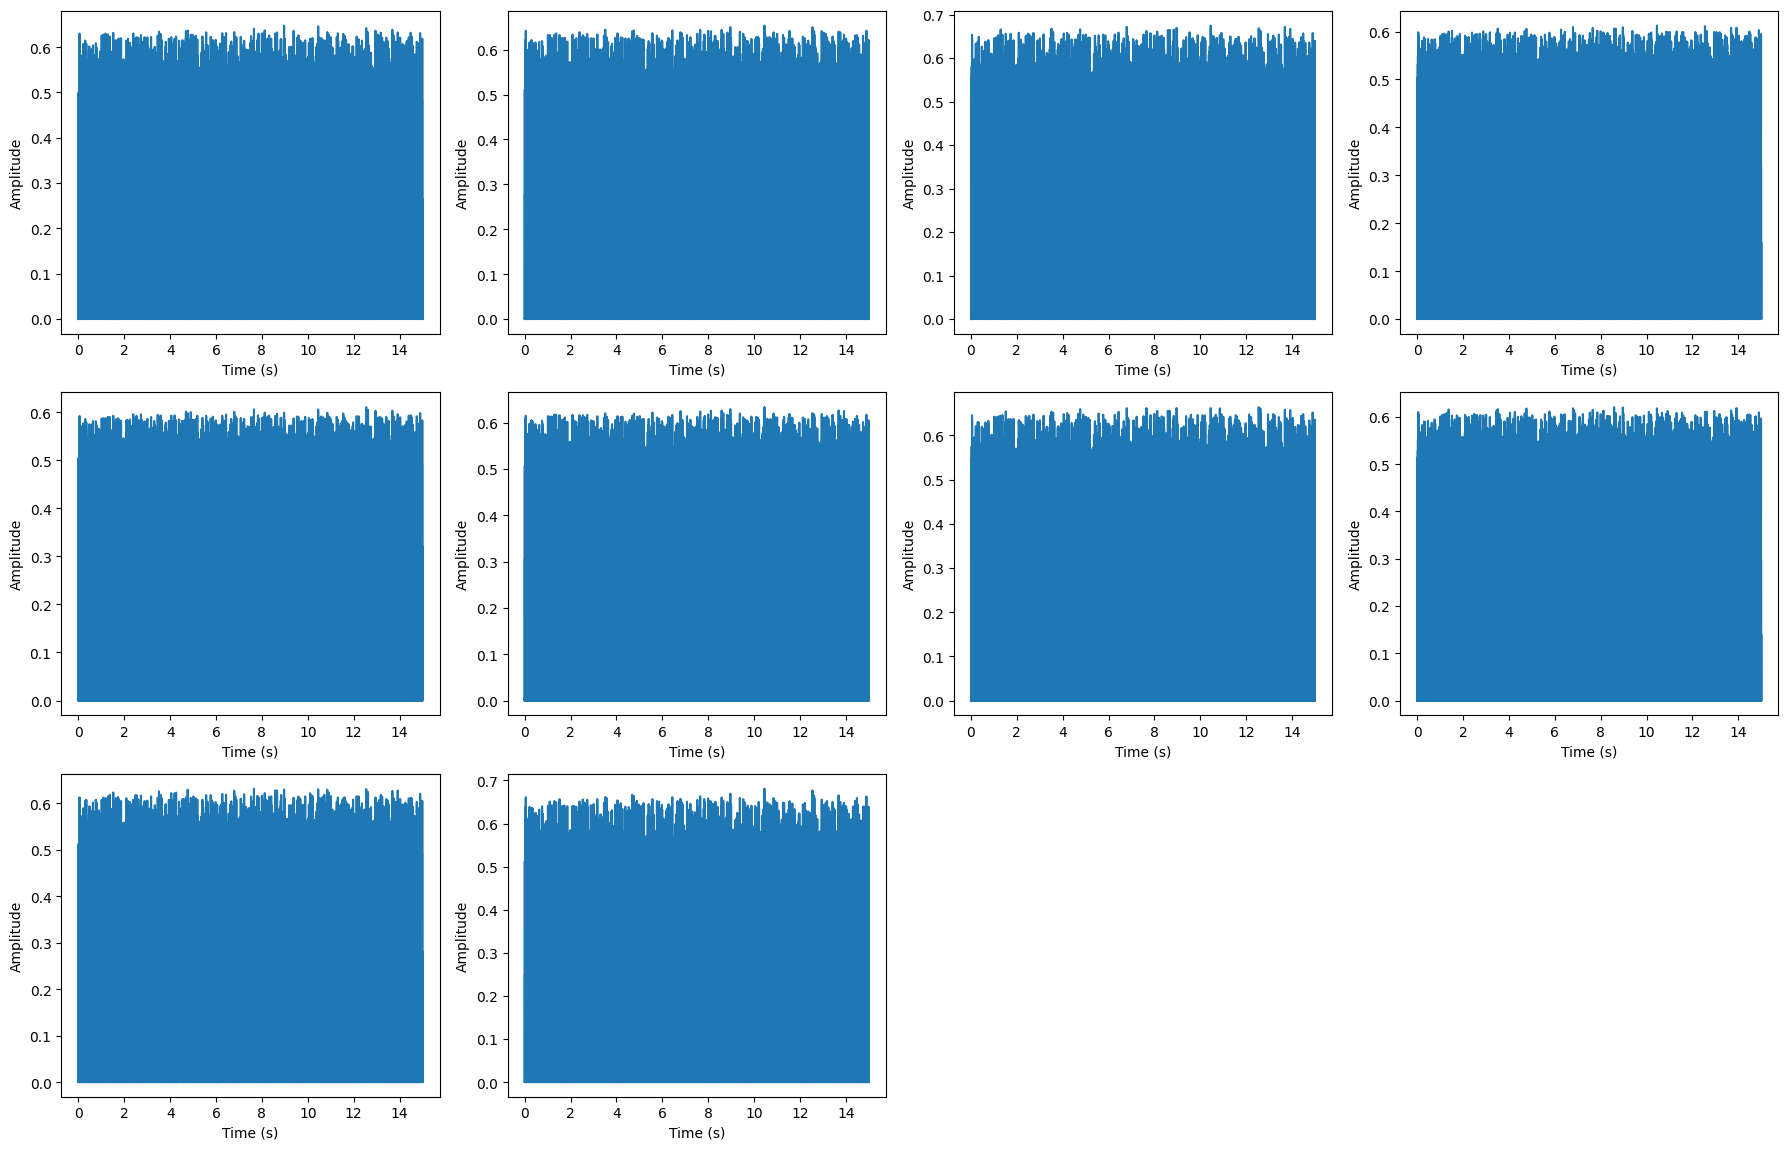

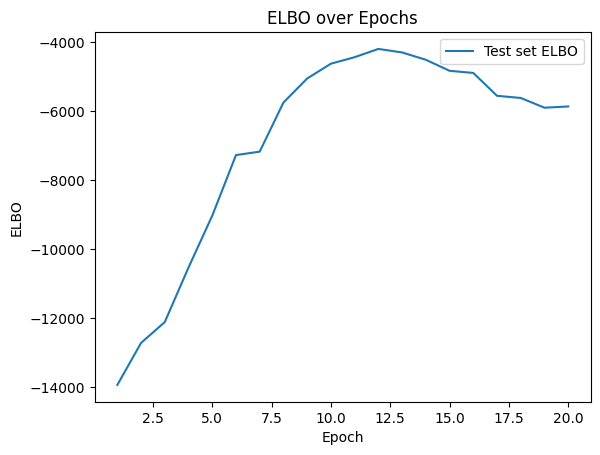

In [176]:
import matplotlib.pyplot as plt

def plot_loss_over_epochs(elbo_values):
    plt.plot(range(1, len(elbo_values) + 1), elbo_values, label='Test set ELBO')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO')
    plt.title('ELBO over Epochs')
    plt.legend()
    plt.show()

def train(train_dataset, test_dataset, model, save):
    elbo_values = []  # List to store test set ELBO values

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        elbo_values.append(elbo)  # Append the ELBO value to the list

        display.clear_output(wait=False)
        print('Epoch: {}, ELBO: {}, time elapsed for current epoch: {}'.format(epoch,
                                                                                         elbo,
                                                                                         end_time - start_time))

        generate_and_save_images(model, epoch, test_sample, save)

    # Plot the test set ELBO values over epochs
    plot_loss_over_epochs(elbo_values)

train(train_dataset, test_dataset, model, 'hiphop')


In [177]:
def inference(test_dataset, model):
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

saved_musics = inference(test_dataset, model)

In [178]:
music1=saved_musics[0][0]
ipd.Audio(music1,rate=3000)

In [173]:
music2=saved_musics[9][0]
ipd.Audio(music2,rate=3000)

In [174]:
music3=saved_musics[5][0]
ipd.Audio(music3,rate=3000)

In [179]:
!pip install soundfile

In [180]:
import soundfile as sf

# music3 is your numpy array containing audio data and 3000 is the sample rate
sf.write('output_audio3.wav', music3, 3000)
print("Audio saved as 'audio3.wav'")

Audio saved as 'audio3.wav'


In [181]:
import soundfile as sf

# Assuming music3 is your numpy array containing audio data and 3000 is the sample rate
sf.write('output_audio2.wav', music2, 3000)
print("Audio saved as 'audio2.wav'")

Audio saved as 'audio2.wav'


In [182]:
import soundfile as sf

# Assuming music3 is your numpy array containing audio data and 3000 is the sample rate
sf.write('output_audio1.wav', music1, 3000)
print("Audio saved as 'audio1.wav'")

Audio saved as 'audio1.wav'
